# 第6章: 機械学習
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
%cd '/content/drive/MyDrive/NLP100knock2024/chapter06/'

/content/drive/MyDrive/NLP100knock2024/chapter06


In [ ]:
!pwd

/content/drive/MyDrive/NLP100knock2024/chapter06


In [ ]:
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

## 50. データの入手・整形
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3. 抽出された事例をランダムに並び替える．
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


extract_list = ['Reuters', 'Huffington Post',
                'Businessweek', 'Contactmusic.com', 'Daily Mail']
header_name = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'
               ]

# pandasで読み込み
# headerはなし．分割はタブ．headerの名前はheader_name．
df = pd.read_csv('./newsCorpora_re.csv', header=None,
                 sep='\t', names=header_name)

# 抽出
# dfの'PUBLISHER'の要素に対しextract_listの要素である場合は，'TITLE'と'CATEGORY'を抽出
df_ex = df.loc[df['PUBLISHER'].isin(extract_list), ['TITLE', 'CATEGORY']]

data_train, data_other = train_test_split(
    df_ex, test_size=0.2, random_state=20010101)
data_valid, data_test = train_test_split(
    data_other, test_size=0.5, random_state=20010101)

data_train.to_csv("train.txt", sep="\t", index=False, header=False)
data_valid.to_csv("valid.txt", sep="\t", index=False, header=False)
data_test.to_csv("test.txt", sep="\t", index=False, header=False)

print("train_data")
print(data_train['CATEGORY'].value_counts())
print("valid_data")
print(data_valid['CATEGORY'].value_counts())
print("test_data")
print(data_test['CATEGORY'].value_counts())

train_data
CATEGORY
b    4503
e    4239
t    1228
m     714
Name: count, dtype: int64
valid_data
CATEGORY
b    568
e    527
t    142
m     99
Name: count, dtype: int64
test_data
CATEGORY
b    556
e    528
t    155
m     97
Name: count, dtype: int64


In [ ]:
df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


## 51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [ ]:
#51
import pandas as pd
import string
import re

#出現単語のカウントをベクトルにする
from sklearn.feature_extraction.text import CountVectorizer
#TF-IDFを計算する
from sklearn.feature_extraction.text import TfidfVectorizer

def prep(text):
    text = "".join([i for i in text if i not in string.punctuation]) #textから記号でないものを抜き出す
    # string.punctuation -> '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    text = text.lower()  # 小文字化
    text = re.sub("[0-9]+", "", text)  # 数字を削除
    return text


header_name = ['TITLE', 'CATEGORY']

train = pd.read_csv('./train.txt', header=None,
                    sep='\t', names=header_name) #names：列名の指定
valid = pd.read_csv('./valid.txt', header=None,
                    sep='\t', names=header_name)
test = pd.read_csv('./test.txt', header=None,
                   sep='\t', names=header_name)

#  concatで結合
df = pd.concat([train, valid, test], axis=0)
df.reset_index(drop=True, inplace=True)

# https://note.nkmk.me/python-pandas-map-applymap-apply/
# それぞれのxに対してprep(x)を返す
# 要は前処理
df["TITLE"] = df["TITLE"].map(lambda x: prep(x)) #TITLEにprep(x)を適用

# 分割
# trainのデータのみを用いてモデルを学習するため
train_d = df[:len(train)]
valid_d = df[len(train):len(train)+len()]
test_d = df[len(train)+len(valid):]

#
#min_df：使用されている文書の割合(0～1)、または②使用されている文章数の下限(整数)を設定
# 使用するn_gramを1～2gramに設定
vec_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

# fit：語彙の獲得、idfの計算
# transform：文書を変換
# fit_transform：fitの計算とtransformの計算を連続で実行
# testのデータを用いずに統計量を獲得し，testはfitで得られた統計量に基づき正則化
# testのデータを含めてfitすると，テストデータを用いて学習しているため不適
train_f = vec_tfidf.fit_transform(train_d["TITLE"])
valid_f = vec_tfidf.transform(valid_d["TITLE"])
test_f = vec_tfidf.transform(test_d["TITLE"])

train_vec = pd.DataFrame(
    train_f.toarray(), columns=vec_tfidf.get_feature_names_out())#get_feature_names()：特徴量ラベル
valid_vec = pd.DataFrame(
    valid_f.toarray(), columns=vec_tfidf.get_feature_names_out())
test_vec = pd.DataFrame(
    test_f.toarray(), columns=vec_tfidf.get_feature_names_out())

train_vec.to_csv("./train.feature.txt", sep="\t", index=False)
valid_vec.to_csv("./valid.feature.txt", sep="\t", index=False)
test_vec.to_csv("./test.feature.txt", sep="\t", index=False)

print(train_vec.head())

    aa  abbvie     about  about the  about to  above  abramson  abuse  \
0  0.0     0.0  0.000000        0.0       0.0    0.0       0.0    0.0   
1  0.0     0.0  0.000000        0.0       0.0    0.0       0.0    0.0   
2  0.0     0.0  0.350617        0.0       0.0    0.0       0.0    0.0   
3  0.0     0.0  0.000000        0.0       0.0    0.0       0.0    0.0   
4  0.0     0.0  0.000000        0.0       0.0    0.0       0.0    0.0   

   accelerates  access  ...  you to  young  your  your mother   yr  yuan  zac  \
0          0.0     0.0  ...     0.0    0.0   0.0          0.0  0.0   0.0  0.0   
1          0.0     0.0  ...     0.0    0.0   0.0          0.0  0.0   0.0  0.0   
2          0.0     0.0  ...     0.0    0.0   0.0          0.0  0.0   0.0  0.0   
3          0.0     0.0  ...     0.0    0.0   0.0          0.0  0.0   0.0  0.0   
4          0.0     0.0  ...     0.0    0.0   0.0          0.0  0.0   0.0  0.0   

   zac efron  zendaya  zone  
0        0.0      0.0   0.0  
1        0.0  

In [ ]:
train.head()

,TITLE,CATEGORY
0,"Kim Kardashian Shares Makeup-Free Selfie, The ...",e
1,Kanye West - Kanye West Booed At Wireless Fest...,e
2,Google deletes search results about millionair...,t
3,Kim Kardashian wears slit-to the-hip gown at M...,e
4,Mickey Rooney's shambolic and desperate last d...,e


## 52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [ ]:
from sklearn.linear_model import LogisticRegression
import pickle #プログラムを実行し終えたあとも保存する機能を提供してくれるモジュール

#ロジスティック回帰
lr = LogisticRegression(random_state=20010101, max_iter=1000) #max_iter：最大学習回数

X_train = pd.read_table("train.feature.txt")
Y_train = train['CATEGORY']

#print(len(X_train))
#print(len(Y_train))

lr.fit(X_train, Y_train)

#logreg.pklに書き込みモードで開く
with open("logreg.pkl", "wb") as f:
    pickle.dump(lr, f)

## 53. 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [ ]:
def score_lr(lr, x):
    return [np.max(lr.predict_proba(x), axis=1), lr.predict(x)] #各サンプルがカテゴリに含まれる確率の最大値と、カテゴリを返す

lr = pickle.load(open("logreg.pkl", 'rb')) #logreg.pklからロード

X_test = pd.read_table("test.feature.txt")

train_pred = score_lr(lr, X_train)
test_pred = score_lr(lr, X_test)

print(train_pred)


[array([0.95639016, 0.95150792, 0.71723264, ..., 0.41618606, 0.79069426,
       0.4043551 ]), array(['e', 'e', 't', ..., 'b', 'b', 'b'], dtype=object)]


## 54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [ ]:
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(train["CATEGORY"], train_pred[1])
test_acc = accuracy_score(test["CATEGORY"], test_pred[1])

print(f"訓練データの正解率:{train_acc:.3f}")
print(f"テストデータの正解率:{test_acc:.3f}")


訓練データの正解率:0.922
テストデータの正解率:0.870


## 55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

訓練データの混同行列
[[4342  104    9   48]
 [  61 4165    2   11]
 [  99  123  481   11]
 [ 217  144    7  860]]
テストデータの混同行列
[[520  23   1  12]
 [ 19 506   1   2]
 [ 13  28  56   0]
 [ 40  33   2  80]]


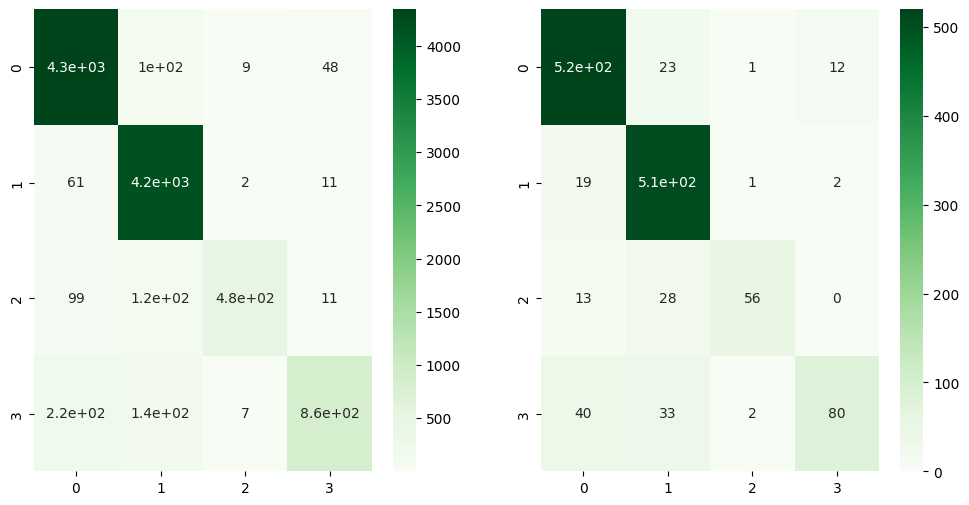

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

train_con = confusion_matrix(train["CATEGORY"], train_pred[1])
test_con = confusion_matrix(test["CATEGORY"], test_pred[1])

print("訓練データの混同行列")
print(train_con)
print("テストデータの混同行列")
print(test_con)

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(train_con, annot=True, cmap="Greens", ax = ax1)
ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(test_con, annot=True, cmap="Greens", ax = ax2)
plt.show()

## 56. 適合率，再現率，F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [ ]:
from sklearn.metrics import *

#classification_report：https://colab.research.google.com/drive/1-OxaX0IAuMz2Fz18yfy83YjL6T2MPq2V#scrollTo=LDwqO3D4Bix_&line=4&uniqifier=1
print(classification_report(test["CATEGORY"], test_pred[1]))

              precision    recall  f1-score   support

           b       0.88      0.94      0.91       556
           e       0.86      0.96      0.91       528
           m       0.93      0.58      0.71        97
           t       0.85      0.52      0.64       155

    accuracy                           0.87      1336
   macro avg       0.88      0.75      0.79      1336
weighted avg       0.87      0.87      0.86      1336



## 57. 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [ ]:
feat = X_train.columns.values #特徴量
ind = [i for i in range(1, 11)] #1から10までの
for c, coef in zip(lr.classes_, lr.coef_): #c：クラス、coef：係数
    top10 = pd.DataFrame(feat[np.argsort(-coef)[:10]], #-coefで降順にする
                         columns=[f"top10 : {c}"], index=ind)
    worst10 = pd.DataFrame(feat[np.argsort(coef)[:10]],
                           columns=[f"worst10 : {c}"], index=ind)
    print(f"{c}'s weight")
    print(top10)
    print(worst10)
    print("---------------------")

b's weight
    top10 : b
1        bank
2         fed
3         ecb
4         oil
5      stocks
6        euro
7     ukraine
8   obamacare
9       china
10      banks
   worst10 : b
1          and
2          her
3        video
4           tv
5        ebola
6        study
7       google
8        aereo
9         star
10         the
---------------------
e's weight
     top10 : e
1        chris
2   kardashian
3        movie
4         film
5      wedding
6          kim
7         fans
8         paul
9          her
10     trailer
   worst10 : e
1           us
2       update
3       google
4        study
5         says
6           gm
7          ceo
8         data
9     facebook
10       china
---------------------
m's weight
   top10 : m
1      ebola
2      study
3     cancer
4        fda
5       mers
6       drug
7     health
8    doctors
9    medical
10     heart
   worst10 : m
1          ceo
2           gm
3     facebook
4         deal
5      climate
6         bank
7        apple
8      twit

## 58. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

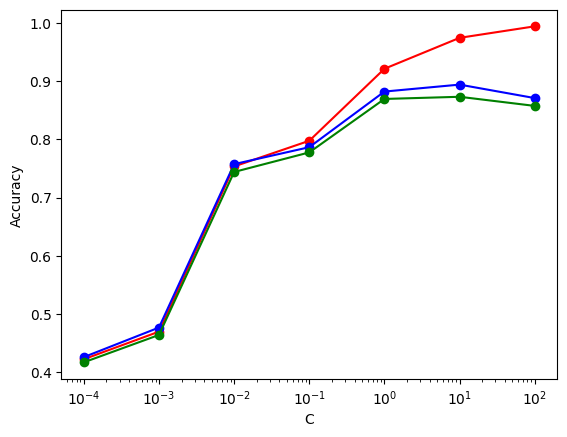

In [ ]:
def learning_model(x_train, y_train, c):
    lr = LogisticRegression(random_state=20010101, max_iter=1000, C=c) #Cは正則化パラメータ
    lr.fit(x_train, y_train)
    model_name = "logreg" + str(c) + ".pkl" #pickleファイルの名前
    with open(model_name, "wb") as f:
        pickle.dump(lr, f)
    return lr


def open_model(c):
    model_name = "logreg" + str(c) + ".pkl"
    with open(model_name, "rb") as f:
        model = pickle.load(f)
    return model

X_train = pd.read_table("train.feature.txt")
X_valid = pd.read_table("valid.feature.txt")
X_test = pd.read_table("test.feature.txt")
Y_train = train["CATEGORY"]
Y_valid = valid["CATEGORY"]
Y_test = test["CATEGORY"]
# 逆数が正則化項に対応するのに注意
regular = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
train_acu = []
valid_acu = []
test_acu = []
for c in regular:
    model = learning_model(X_train, Y_train, c)
    model = open_model(c)
    train_pred = score_lr(model, X_train)
    valid_pred = score_lr(model, X_valid)
    test_pred = score_lr(model, X_test)
    train_acu.append(accuracy_score(train["CATEGORY"], train_pred[1]))
    valid_acu.append(accuracy_score(valid["CATEGORY"], valid_pred[1]))
    test_acu.append(accuracy_score(test["CATEGORY"], test_pred[1]))
plt.plot(regular, train_acu,  marker="o", color="red", label="train")
plt.plot(regular, valid_acu,  marker="o", color="blue", label="valid")
plt.plot(regular, test_acu,  marker="o", color="green", label="test")
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.savefig("regular_parameter")

## 59. ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [i for i in range(1, 21)]}

grid_search = GridSearchCV(LogisticRegression(
    random_state=20010101, max_iter=1000), param_grid, cv=5)
grid_search.fit(X_train, Y_train)

print("Best parameters : {}".format(grid_search.best_params_))
print("Best cross-validation score : {:.3f}".format(grid_search.best_score_))


Best parameters : {'C': 5}
Best cross-validation score : 0.882
